# 1. autoencoder

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from keras.datasets import cifar10
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from keras.engine import Model
from keras import optimizers
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
tfkl = tfk.layers

In [3]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
y_train = tf.keras.utils.to_categorical(trainy)
y_test = tf.keras.utils.to_categorical(testy)
x_train = trainX.astype('float32')
x_test = testX.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

170500096/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [8]:
# Define the Model
input_img = keras.Input(shape=(32, 32, 3))
x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
encoded = tfkl.MaxPooling2D((2, 2), padding='same')(x)

x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.UpSampling2D((2, 2))(x)
decoded = tfkl.Conv2D(3, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        4608      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)         

In [9]:
eary_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=7, verbose=1,mode='auto')
callbacks = [eary_stopping]
autoencoder_history = autoencoder.fit(x_train, x_train,epochs=30,batch_size=64, shuffle = True, validation_data=(x_test, x_test), callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - 6s 7ms/step - loss: 0.5904 - val_loss: 0.5845
Epoch 2/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5778 - val_loss: 0.5786
Epoch 3/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5754 - val_loss: 0.5772
Epoch 4/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5740 - val_loss: 0.5746
Epoch 5/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5732 - val_loss: 0.5740
Epoch 6/30
782/782 [==============================] - 5s 6ms/step - loss: 0.5726 - val_loss: 0.5795
Epoch 7/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5720 - val_loss: 0.5734
Epoch 8/30
782/782 [==============================] - 5s 6ms/step - loss: 0.5716 - val_loss: 0.5743
Epoch 9/30
782/782 [==============================] - 5s 6ms/step - loss: 0.5712 - val_loss: 0.5745
Epoch 10/30
782/782 [==============================] - 5s 6ms/step - loss: 0.5709 - val_loss: 0.5713

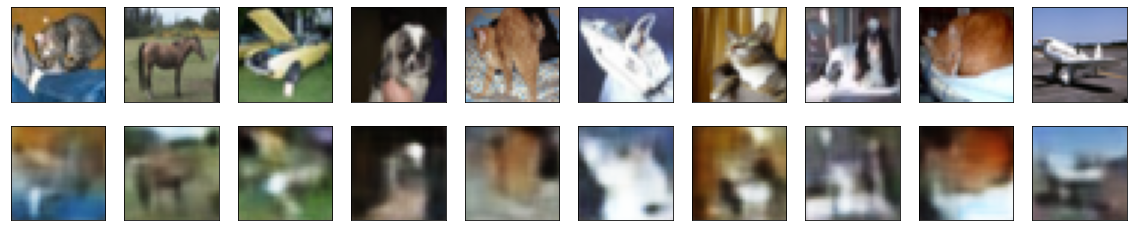

In [10]:
# Visualize
decoded_imgs = autoencoder.predict(x_test)
def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[-i].reshape(32, 32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[-i].reshape(32, 32,3))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
display_reconstructed(x_test, decoded_imgs, 10)

# 2.1 deep CNN

In [15]:
# CNN Model 
model = tfk.Sequential()
model.add(tfkl.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.Conv2D(32, (3, 3), padding ='same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid', data_format = None))
model.add(tfkl.Dropout(0.4))
model.add(tfkl.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'same', data_format = None))
model.add(tfkl.Dropout(0.4))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(128, input_shape = (128, )))
model.add(tfkl.Dense(10))
model.add(tfkl.LeakyReLU(0.1))
model.add(tfkl.Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)         

In [16]:
# Train the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
eary_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
callbacks = [eary_stopping]
deep_cnn_history = model.fit(x_train, y_train, batch_size=64,epochs=100, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/100
782/782 [==============================] - 5s 6ms/step - loss: 1.5443 - accuracy: 0.4398 - val_loss: 1.1688 - val_accuracy: 0.5787
Epoch 2/100
782/782 [==============================] - 4s 6ms/step - loss: 1.1452 - accuracy: 0.5915 - val_loss: 1.0253 - val_accuracy: 0.6424
Epoch 3/100
782/782 [==============================] - 4s 6ms/step - loss: 0.9962 - accuracy: 0.6491 - val_loss: 0.9103 - val_accuracy: 0.6803
Epoch 4/100
782/782 [==============================] - 4s 6ms/step - loss: 0.9128 - accuracy: 0.6800 - val_loss: 0.8269 - val_accuracy: 0.7089
Epoch 5/100
782/782 [==============================] - 4s 6ms/step - loss: 0.8562 - accuracy: 0.6992 - val_loss: 0.8009 - val_accuracy: 0.7198
Epoch 6/100
782/782 [==============================] - 4s 6ms/step - loss: 0.8176 - accuracy: 0.7117 - val_loss: 0.7938 - val_accuracy: 0.7218
Epoch 7/100
782/782 [==============================] - 4s 6ms/step - loss: 0.7902 - accuracy: 0.7211 - val_loss: 0.7805 - val_accuracy: 0.7255

In [17]:
#check accuracy
score = model.evaluate(x_test, y_test, verbose=1)
print("The test score: {acc}".format(acc = score))

313/313 [==============================] - 1s 3ms/step - loss: 0.6859 - accuracy: 0.7648
The test score: [0.6858810782432556, 0.7648000121116638]


2.2 Transfer Learning

In [18]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [19]:
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])

In [20]:
base_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))
last = base_model.get_layer('block3_pool').output
# Add classification layers on top of it
x = tfkl.GlobalAveragePooling2D()(last)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dense(256, activation='relu')(x)
x = tfkl.Dense(256, activation='relu')(x)
x = tfkl.Dropout(0.6)(x)
pred = tfkl.Dense(10, activation='softmax')(x)
model = Model(base_model.input, pred)

58892288/58889256 [==============================] - 1s 0us/step


In [21]:
for layer in base_model.layers:
     layer.trainable = False
model.compile(loss='binary_crossentropy',
              optimizer = optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

In [22]:
# Model training
eary_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
callbacks = [eary_stopping]
vgg_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3262 - accuracy: 0.1356 - val_loss: 0.3174 - val_accuracy: 0.1586
Epoch 2/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3195 - accuracy: 0.1487 - val_loss: 0.3161 - val_accuracy: 0.1664
Epoch 3/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3181 - accuracy: 0.1547 - val_loss: 0.3149 - val_accuracy: 0.1663
Epoch 4/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3173 - accuracy: 0.1584 - val_loss: 0.3144 - val_accuracy: 0.1666
Epoch 5/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3167 - accuracy: 0.1612 - val_loss: 0.3140 - val_accuracy: 0.1706
Epoch 6/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3163 - accuracy: 0.1608 - val_loss: 0.3139 - val_accuracy: 0.1704
Epoch 7/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3158 - accuracy: 0.1631 - val_loss: 0.3132 - val_ac

In [24]:
score = model.evaluate(x_test, y_test, verbose=1)
print("The test score: {acc}".format(acc = score))

313/313 [==============================] - 2s 6ms/step - loss: 0.3115 - accuracy: 0.1812
The test score: [0.31154555082321167, 0.18119999766349792]


3.1 RNN

In [29]:
data = pd.read_csv("/SPAM_detection.csv")   
x = data['Message']
y = data['category_val']
# Train Test splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(3900,), y=(3900,)
Test: X=(1672,), y=(1672,)


In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
word_dict = tokenizer.index_word  
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_seq, maxlen=50, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=50, padding='post')

In [31]:
# LSTM model
laenge_pads = 50
anz_woerter = 9004
lstm_model = tfk.Sequential()
lstm_model.add(tfkl.Embedding(input_dim=anz_woerter+1,  output_dim=50, input_length=laenge_pads))   
lstm_model.add(tfkl.LSTM(400))
lstm_model.add(tfkl.Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer = optimizers.Adam(lr=1e-4),  metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            450250    
_________________________________________________________________
lstm (LSTM)                  (None, 400)               721600    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 401       
Total params: 1,172,251
Trainable params: 1,172,251
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Model Training
eary_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
callbacks = [eary_stopping]
lstm_history = lstm_model.fit(x_train_pad, y_train, batch_size=32, epochs=20, validation_data=(x_test_pad, y_test), callbacks=callbacks)

Epoch 1/20
122/122 [==============================] - 2s 18ms/step - loss: 0.3504 - accuracy: 0.8838 - val_loss: 0.1503 - val_accuracy: 0.9551
Epoch 2/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0938 - accuracy: 0.9723 - val_loss: 0.1139 - val_accuracy: 0.9677
Epoch 3/20
122/122 [==============================] - 2s 13ms/step - loss: 0.0563 - accuracy: 0.9849 - val_loss: 0.1185 - val_accuracy: 0.9641
Epoch 4/20
122/122 [==============================] - 1s 12ms/step - loss: 0.0342 - accuracy: 0.9923 - val_loss: 0.0958 - val_accuracy: 0.9695
Epoch 5/20
122/122 [==============================] - 2s 12ms/step - loss: 0.0221 - accuracy: 0.9954 - val_loss: 0.1011 - val_accuracy: 0.9707
Epoch 6/20
122/122 [==============================] - 1s 12ms/step - loss: 0.0146 - accuracy: 0.9972 - val_loss: 0.1496 - val_accuracy: 0.9653
Epoch 7/20
122/122 [==============================] - 2s 12ms/step - loss: 0.0094 - accuracy: 0.9987 - val_loss: 0.1688 - val_accuracy: 0.9689

In [33]:
score = lstm_model.evaluate(x_test_pad, y_test, verbose=1)
print("The test score: {acc}".format(acc = score))

53/53 [==============================] - 0s 6ms/step - loss: 0.1688 - accuracy: 0.9689
The test score: [0.1687932312488556, 0.9688995480537415]


3.2 CNN

In [34]:
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(x_train)
train_sequences = tk.texts_to_sequences(x_train)
test_texts = tk.texts_to_sequences(x_test)
train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
test_data = pad_sequences(test_texts, maxlen=1014, padding='post')
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

In [37]:
vocab_size = len(tk.word_index)
embedding_weights = []
embedding_weights.append(np.zeros(vocab_size))
for char,i in tk.word_index.items():   
  onehot = np.zeros(vocab_size)
  onehot[i-1] = 1
  embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)
print(embedding_weights.shape)

(88, 87)


In [41]:
input_size = 1014
vocab_size = len(tk.word_index)
embedding_size = 87
conv_layers = [[256, 7, 3],[256, 7, 3],[256, 3, -1],[256, 3, -1],[256, 3, -1],[256, 3, 3]]
fully_connected_layers = [1024, 1024]
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'    
# Embedding layer Initialization
embedding_layer = tfkl.Embedding(vocab_size+1,
                            embedding_size,
                            input_length = input_size,
                            weights = [embedding_weights])

In [42]:

inputs = tfkl.Input(shape=(input_size,), name='input', dtype='int64') 
x = embedding_layer(inputs)
for filter_num, filter_size, pooling_size in conv_layers:
    x = tfkl.Conv1D(filter_num, filter_size)(x)
    x = tfkl.Activation('relu')(x)
    if pooling_size != -1:
        x = tfkl.MaxPooling1D(pool_size=pooling_size)(x)  
x = tfkl.Flatten()(x) 
for dense_size in fully_connected_layers:
    x = tfkl.Dense(dense_size, activation='relu')(x)  
    x = tfkl.Dropout(dropout_p)(x)
predictions = tfkl.Dense(1, activation='sigmoid')(x)
cnn_model = Model(inputs=inputs, outputs=predictions)
cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
cnn_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1014)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1014, 87)          7656      
_________________________________________________________________
conv1d (Conv1D)              (None, 1008, 256)         156160    
_________________________________________________________________
activation_3 (Activation)    (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 336, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
activation_4 (Activation)    (None, 330, 256)         

In [43]:
eary_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3,verbose=1, mode='auto')
callbacks = [eary_stopping]
CNN_history = cnn_model.fit(train_data, y_train, batch_size=32, epochs=20, validation_data=(test_data, y_test), callbacks=callbacks)

Epoch 1/20
122/122 [==============================] - 5s 40ms/step - loss: 0.1773 - accuracy: 0.9431 - val_loss: 0.1027 - val_accuracy: 0.9761
Epoch 2/20
122/122 [==============================] - 5s 37ms/step - loss: 0.0927 - accuracy: 0.9779 - val_loss: 0.0865 - val_accuracy: 0.9821
Epoch 3/20
122/122 [==============================] - 5s 38ms/step - loss: 0.0574 - accuracy: 0.9862 - val_loss: 0.1023 - val_accuracy: 0.9743
Epoch 4/20
122/122 [==============================] - 5s 37ms/step - loss: 0.0456 - accuracy: 0.9905 - val_loss: 0.1012 - val_accuracy: 0.9827
Epoch 5/20
122/122 [==============================] - 5s 37ms/step - loss: 0.0444 - accuracy: 0.9926 - val_loss: 0.0736 - val_accuracy: 0.9833
Epoch 6/20
122/122 [==============================] - 4s 37ms/step - loss: 0.0416 - accuracy: 0.9913 - val_loss: 0.0830 - val_accuracy: 0.9773
Epoch 7/20
122/122 [==============================] - 4s 37ms/step - loss: 0.0387 - accuracy: 0.9918 - val_loss: 0.0825 - val_accuracy: 0.9833

In [44]:
score = cnn_model.evaluate(test_data, y_test, verbose=1)
print("The test score: {acc}".format(acc = score))

53/53 [==============================] - 1s 13ms/step - loss: 0.1327 - accuracy: 0.9821
The test score: [0.13274303078651428, 0.9820573925971985]


3.3 compare

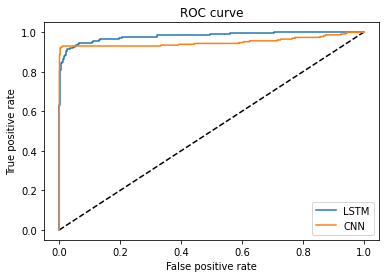

In [46]:
y_pred_keras = lstm_model.predict(x_test_pad).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
cnn_y_pred_keras = cnn_model.predict(test_data).ravel()
cnn_fpr_keras, cnn_tpr_keras, cnn_thresholds_keras = roc_curve(y_test, cnn_y_pred_keras)
cnn_auc_keras = auc(cnn_fpr_keras, cnn_tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM'.format(auc_keras))
plt.plot(cnn_fpr_keras, cnn_tpr_keras, label='CNN'.format(cnn_auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#LSTM shows better performance.